In [1]:
import torch
import torch.nn as nn
from torch.optim import AdamW, Adam, SGD
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import LambdaLR
import torch.nn.functional as F

import pandas as pd
from tqdm.auto import tqdm

In [2]:
from timeit import default_timer as timer
from torch.profiler import profile, record_function, ProfilerActivity

In [3]:
# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Utils Function

In [4]:
def print_train_time(start:float, end:float, device: torch.device = None):
    """print difference between start and end time"""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [5]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [6]:
def results(res: str):
    res_lst = res.split('\n')

    data = []
    for row in res_lst[3:-4]:
        row_split = [sp.strip() for sp in row[57:].split('  ') if sp != '']
        data.append(row_split)

    index = [l[:57].strip() for l in res_lst[3:-4]]

    head = [c.strip() for c in res_lst[1].strip().split('  ') if c != '']

    df = pd.DataFrame(data, columns=None)
    df.columns = head[1:]
    df.index = index

    return df

# Model CNN

In [7]:
from model import CNNModel
from training_function import train_step, test_step, accuracy_fn

# Data

In [8]:
import joblib
from torch.utils import data

In [9]:
train_data = 'train.jb'
valid_data = 'test.jb'

In [10]:
n_workers = 0
valid_steps = 1
save_steps = 50
epochs = 25

lr = 3e-05
batch_size = 128

In [11]:
train_x, train_y = joblib.load(train_data)
val_x, val_y = joblib.load(valid_data)

train_y, val_y = pd.get_dummies(train_y).values, pd.get_dummies(val_y).values

train_set = data.TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
valid_set = data.TensorDataset(torch.Tensor(val_x), torch.Tensor(val_y))

In [12]:
train_x.shape, val_x.shape

((6900, 3, 500), (3477, 3, 500))

In [13]:
train_dataloader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=n_workers,
    pin_memory=True
  )

valid_dataloader = DataLoader(
    valid_set,
    batch_size=len(valid_set),
    num_workers=n_workers,
    drop_last=True,
    pin_memory=True
  )

# Training Model CNN GPU

In [14]:
# Create an instance of model_1
torch.manual_seed(42)
model = CNNModel().to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [15]:
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch:0.9**epoch)
loss_fn = nn.CrossEntropyLoss()

In [16]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True) as prof:
    start_time = timer()
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}\n-------------")

        train_step(model=model,
                   data_loader=train_dataloader, 
                   loss_fn=loss_fn,
                   optimizer=optimizer,
                   accuracy_fn=accuracy_fn,
                   device=device)

        test_step(model=model,
                   data_loader=valid_dataloader, 
                   loss_fn=loss_fn,
                   accuracy_fn=accuracy_fn,
                   device=device)
        scheduler.step()
        prof.step()
    end_time = timer()
print(f'Time Consumtion: {end_time-start_time} sec')

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0
-------------
Train loss: 0.43773 | Train acc: 85.35%
Test loss: 0.31934 | Test acc: 93.13 %

Epoch: 1
-------------
Train loss: 0.31105 | Train acc: 87.93%
Test loss: 0.21773 | Test acc: 93.18 %

Epoch: 2
-------------
Train loss: 0.27246 | Train acc: 88.24%
Test loss: 0.21439 | Test acc: 94.13 %

Epoch: 3
-------------
Train loss: 0.25471 | Train acc: 88.94%
Test loss: 0.20503 | Test acc: 93.67 %

Epoch: 4
-------------
Train loss: 0.24158 | Train acc: 89.55%
Test loss: 0.18686 | Test acc: 94.13 %

Epoch: 5
-------------
Train loss: 0.23409 | Train acc: 89.96%
Test loss: 0.17100 | Test acc: 94.16 %

Epoch: 6
-------------
Train loss: 0.22222 | Train acc: 90.54%
Test loss: 0.15398 | Test acc: 94.28 %

Epoch: 7
-------------
Train loss: 0.21497 | Train acc: 90.68%
Test loss: 0.17188 | Test acc: 94.56 %

Epoch: 8
-------------
Train loss: 0.21074 | Train acc: 90.89%
Test loss: 0.15181 | Test acc: 94.51 %

Epoch: 9
-------------
Train loss: 0.20626 | Train acc: 91.16%
Test loss:

In [17]:
res = prof.key_averages().table()
print(res)

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         0.45%     136.058ms         0.45%     136.058ms       3.270us      61.369ms         0.19%      61.369ms       1.475us       3.74 Mb       3.74 Mb      32.86 Gb      32.86 G

In [18]:
df = results(res)
df.to_csv('cnn_cuda.csv')

# Training Model CNN CPU

In [19]:
# Create an instance of model_1
torch.manual_seed(42)
device = 'cpu'
model = CNNModel().to(device)
next(model.parameters()).device

device(type='cpu')

In [20]:
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch:0.9**epoch)
loss_fn = nn.CrossEntropyLoss()

In [21]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True) as prof:
    start_time = timer()
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}\n-------------")

        train_step(model=model,
                   data_loader=train_dataloader, 
                   loss_fn=loss_fn,
                   optimizer=optimizer,
                   accuracy_fn=accuracy_fn,
                   device=device)

        test_step(model=model,
                   data_loader=valid_dataloader, 
                   loss_fn=loss_fn,
                   accuracy_fn=accuracy_fn,
                   device=device)
        scheduler.step()
        prof.step()
    end_time = timer()
print(f'Time Consumtion: {end_time-start_time} sec')

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0
-------------
Train loss: 0.43772 | Train acc: 85.35%
Test loss: 0.31929 | Test acc: 93.13 %

Epoch: 1
-------------
Train loss: 0.31105 | Train acc: 87.93%
Test loss: 0.21772 | Test acc: 93.18 %

Epoch: 2
-------------
Train loss: 0.27247 | Train acc: 88.24%
Test loss: 0.21417 | Test acc: 94.13 %

Epoch: 3
-------------
Train loss: 0.25473 | Train acc: 88.93%
Test loss: 0.20503 | Test acc: 93.67 %

Epoch: 4
-------------
Train loss: 0.24160 | Train acc: 89.55%
Test loss: 0.18687 | Test acc: 94.13 %

Epoch: 5
-------------
Train loss: 0.23411 | Train acc: 89.95%
Test loss: 0.17100 | Test acc: 94.16 %

Epoch: 6
-------------
Train loss: 0.22224 | Train acc: 90.54%
Test loss: 0.15399 | Test acc: 94.28 %

Epoch: 7
-------------
Train loss: 0.21499 | Train acc: 90.68%
Test loss: 0.17191 | Test acc: 94.56 %

Epoch: 8
-------------
Train loss: 0.21076 | Train acc: 90.89%
Test loss: 0.15181 | Test acc: 94.51 %

Epoch: 9
-------------
Train loss: 0.20627 | Train acc: 91.16%
Test loss:

In [22]:
res = prof.key_averages().table()
print(res)

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         0.50%     355.782ms         0.50%     355.782ms       6.627us        2.007s         2.90%        2.007s      37.389us      55.31 Gb      55.31 Gb         53687  
                                          aten::random_         0.00%     632.000us         0.0

In [23]:
df = results(res)
df.to_csv('cnn_cpu.csv')

# Resource Consumtions of the Model

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [25]:
count_parameters(model)

638850

In [26]:
device = 'cpu'
model.to(device)

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True) as prof:
    with torch.inference_mode():
        start_time = timer()
        for X, y in valid_dataloader:
            # Send the data to the target device
            X, y = X.to(device), y.to(device)

            test_pred = model(X)
            
        end_time = timer()
print(f'Time Consumtion: {end_time-start_time} sec')

Time Consumtion: 1.0582348000000366 sec


In [27]:
res = prof.key_averages().table()
print(res)
df = results(res)
df.to_csv('run_test_cnn_cpu.csv')

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         0.09%     896.000us         0.09%     896.000us      42.667us      89.000us         0.01%      89.000us       4.238us     421.89 Mb     421.89 Mb            21  
                                          aten::random_         0.16%       1.517ms         0.1

In [28]:
device = 'cuda'
model.to(device)
model.eval()
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True) as prof:
    with torch.inference_mode():
        start_time = timer()
        for X, y in valid_dataloader:
            # Send the data to the target device
            X, y = X.to(device), y.to(device)

            test_pred = model(X)
            
        end_time = timer()
print(f'Time Consumtion: {end_time-start_time} sec')

Time Consumtion: 0.8329820000000154 sec


In [29]:
res = prof.key_averages().table()
print(res)
df = results(res)
df.to_csv('run_test_cnn_gpu.csv')

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         0.05%     385.000us         0.05%     385.000us      25.667us     154.000us         0.02%     154.000us      10.267us         592 b         592 b     318.00 Mb     318.00 M

In [30]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
y_pred = test_pred.argmax(dim=1).cpu().numpy()
y_true = y.argmax(dim=1).cpu().numpy()
precision_recall_fscore_support(y_true, y_pred)

(array([0.9703125 , 0.89422028]),
 array([0.96241767, 0.91517857]),
 array([0.96634896, 0.90457805]),
 array([2581,  896], dtype=int64))

In [32]:
cf_matrix = confusion_matrix(y_true, y_pred)

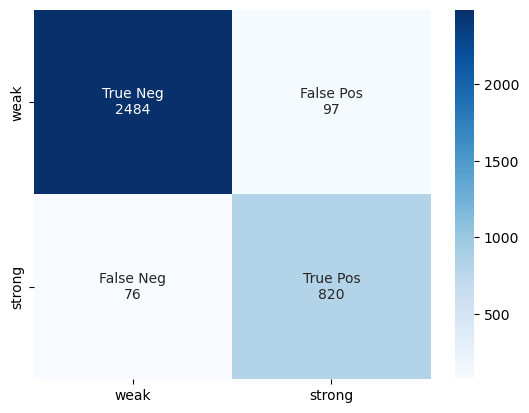

In [33]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2,2)

categories = ["weak", "strong"]
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',xticklabels=categories, yticklabels=categories)
plt.savefig('cf_mat_cnn.png')